# Прогнозирование оттока клиентов
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib

Using matplotlib backend: Qt5Agg


# 1. Загрузка и анализ данных
---

## 1.1 Загрузка

In [2]:
PATH_TO_DATA = 'D:\Задача 1\Данные для задачи - Ренессанс.txt'
data = pd.read_csv(PATH_TO_DATA, header=0, sep=';', quotechar='"')
pd.set_option('precision', 2)
data.head()

,DATA_TYPE,POLICY_ID,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,...,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
0,TRAIN,1,1,1,1,39,1,Москва,51,12,...,N,1,0,0,0.0,0,0,0.0,Тульская,-1.00
1,TRAIN,2,1,1,1,50,5,Москва,35,7,...,0,1,1,0,0.0,0,4,0.0,Москва,-0.05
2,TRAIN,3,1,1,1,52,6,Москва,41,6,...,1L,0,0,0,0.0,0,1,12518.0,Московская,-0.07
3,TRAIN,4,1,1,1,50,5,Москва,36,12,...,0,1,1,0,0.0,0,6,15000.0,Москва,0.05
4,TRAIN,5,1,1,0,52,6,Санкт-Петербург,42,5,...,N,0,0,0,0.0,0,0,50000.0,Ленинградская,0.17


In [3]:
data.shape

(96605, 30)

Проведем проверку на дубликаты строк.

In [4]:
data[data.duplicated()]

,DATA_TYPE,POLICY_ID,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,...,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE


Видно, что дубликовто не обнаружено.

## 1.2 Проверка на пропуски

In [5]:
data.isna().any()

DATA_TYPE                        False
POLICY_ID                        False
POLICY_BEGIN_MONTH               False
POLICY_END_MONTH                 False
POLICY_IS_RENEWED                False
POLICY_SALES_CHANNEL             False
POLICY_SALES_CHANNEL_GROUP       False
POLICY_BRANCH                    False
POLICY_MIN_AGE                   False
POLICY_MIN_DRIVING_EXPERIENCE    False
VEHICLE_MAKE                     False
VEHICLE_MODEL                    False
VEHICLE_ENGINE_POWER             False
VEHICLE_IN_CREDIT                False
VEHICLE_SUM_INSURED              False
POLICY_INTERMEDIARY              False
INSURER_GENDER                   False
POLICY_CLM_N                     False
POLICY_CLM_GLT_N                 False
POLICY_PRV_CLM_N                 False
POLICY_PRV_CLM_GLT_N             False
CLIENT_HAS_DAGO                  False
CLIENT_HAS_OSAGO                 False
POLICY_COURT_SIGN                False
CLAIM_AVG_ACC_ST_PRD             False
POLICY_HAS_COMPLAINTS    

Пропусков данных не обнаружено

## 1.3 Выделение признаков

Выделим в отдельные списки категориальные и числовые признаки для того, чтобы в дальнейшем их было легко трансформировать для разных моделей обучения

In [6]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print ('Категориальные:')
print (categorical_columns)
print ('Вещестыенные:')
print (numerical_columns)

Категориальные:
['DATA_TYPE', 'POLICY_BRANCH', 'VEHICLE_MAKE', 'VEHICLE_MODEL', 'POLICY_INTERMEDIARY', 'INSURER_GENDER', 'POLICY_CLM_N', 'POLICY_CLM_GLT_N', 'POLICY_PRV_CLM_N', 'POLICY_PRV_CLM_GLT_N', 'POLICY_YEARS_RENEWED_N', 'CLIENT_REGISTRATION_REGION']
Вещестыенные:
['POLICY_ID', 'POLICY_BEGIN_MONTH', 'POLICY_END_MONTH', 'POLICY_IS_RENEWED', 'POLICY_SALES_CHANNEL', 'POLICY_SALES_CHANNEL_GROUP', 'POLICY_MIN_AGE', 'POLICY_MIN_DRIVING_EXPERIENCE', 'VEHICLE_ENGINE_POWER', 'VEHICLE_IN_CREDIT', 'VEHICLE_SUM_INSURED', 'CLIENT_HAS_DAGO', 'CLIENT_HAS_OSAGO', 'POLICY_COURT_SIGN', 'CLAIM_AVG_ACC_ST_PRD', 'POLICY_HAS_COMPLAINTS', 'POLICY_DEDUCT_VALUE', 'POLICY_PRICE_CHANGE']


Проведем исследование категориальных признаков.

In [7]:
data[categorical_columns].describe()

,DATA_TYPE,POLICY_BRANCH,VEHICLE_MAKE,VEHICLE_MODEL,POLICY_INTERMEDIARY,INSURER_GENDER,POLICY_CLM_N,POLICY_CLM_GLT_N,POLICY_PRV_CLM_N,POLICY_PRV_CLM_GLT_N,POLICY_YEARS_RENEWED_N,CLIENT_REGISTRATION_REGION
count,96605,96605,96605,96605,96605,96605,96605,96605,96605,96605,96605,96605
unique,2,2,83,549,1406,2,7,7,7,7,12,85
top,TRAIN,Москва,Kia,RAV4,N,M,0,0,0,0,0,Санкт-Петербург
freq,77407,50697,11050,4186,20630,61044,68111,72295,44587,48153,33249,38854


In [8]:
for c in categorical_columns:
    print (c, data[c].unique());

DATA_TYPE ['TRAIN' 'TEST ']
POLICY_BRANCH ['Москва' 'Санкт-Петербург']
VEHICLE_MAKE ['Land Rover' 'Opel' 'Kia' 'Citroen' 'Renault' 'Suzuki' 'Hyundai' 'BMW'
 'Skoda' 'Volkswagen' 'Ssang Yong' 'Toyota' 'Ford' 'Fiat' 'Honda' 'Mazda'
 'Mitsubishi' 'Peugeot' 'Nissan' 'ГАЗ' 'Dodge' 'Lifan' 'Audi' 'УАЗ'
 'Volvo' 'Porsche' 'Subaru' 'ВАЗ' 'Chevrolet' 'Daewoo' 'Lada'
 'Mercedes-Benz' 'Lexus' 'Другая марка (Иностранного производства)' 'Seat'
 'Jeep' 'Infiniti' 'Acura' 'Mini'
 'Другая марка (Отечественного производства)' 'Geely' 'Great Wall'
 'Datsun' 'Chrysler' 'Chery' 'Cadillac' 'Jaguar' 'Smart' 'Tagaz' 'Vortex'
 'Brilliance' 'КАМАЗ' 'Saab' 'Scania' 'Wielton' 'Faw' 'Hummer' 'Daihatsu'
 'Changan' 'MAN' 'DAF' 'BYD' 'Lincoln' 'Alfa Romeo' 'Bogdan' 'Maserati'
 'Haima' 'Scion' 'Jcb' 'Купава' 'Rolls-Royce' 'Rover' 'ПАЗ' 'Bentley'
 'Ferrari' 'ИПВ' 'Iveco' 'Kogel' 'ИЖ' 'Krone' 'Hafei' '<Пусто>' 'МАЗ']
VEHICLE_MODEL ['Discovery' 'Zafira' 'Soul' 'C-Crosser' 'Logan' 'Grand Vitara' 'Sorento'
 'Santa Fe' 'X3

Из вывода выше видно, что есть поля типа N, n/d, <Пусто>. Скорее всего это заполненные пустые поля типа (None). Оставим эти значения в данных, так как за нас их уже кто-то заполнил. Иначе, нам бы пришлось заполнять эти значения модой.

#### Выделяем бинарные признаки

In [9]:
data_describe = data.describe(include=[object])
binary_columns = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
for i in binary_columns:
    if i in categorical_columns:
        categorical_columns.remove(i)
binary_columns += ['VEHICLE_IN_CREDIT','CLIENT_HAS_DAGO','CLIENT_HAS_OSAGO','POLICY_COURT_SIGN','POLICY_HAS_COMPLAINTS']
for i in binary_columns:
    if i in numerical_columns:
        numerical_columns.remove(i) #удаляем дубликаты из списка
print('Бинарные признаки: ', binary_columns)

Бинарные признаки:  ['DATA_TYPE', 'POLICY_BRANCH', 'INSURER_GENDER', 'VEHICLE_IN_CREDIT', 'CLIENT_HAS_DAGO', 'CLIENT_HAS_OSAGO', 'POLICY_COURT_SIGN', 'POLICY_HAS_COMPLAINTS']


#### Выделяем в отдельный лист числовые признаки похожие на категориальные

In [10]:
num_categorical_columns = ['POLICY_SALES_CHANNEL_GROUP', 'POLICY_SALES_CHANNEL', 'POLICY_END_MONTH', 'POLICY_BEGIN_MONTH']
for i in num_categorical_columns:
    numerical_columns.remove(i)

## 1.4 Чистка данных

Есть колонки, которые смысла не несут, это DATA_TYPE - тип выборки и POLICY_ID - ID полиса. Также удалим из набора столбец POLICY_IS_RENEWED - прогнозируемый параметр

In [13]:
numerical_columns.remove('POLICY_IS_RENEWED')
binary_columns.remove('DATA_TYPE')
numerical_columns.remove('POLICY_ID')

### Поиск выбросов

In [29]:
data[numerical_columns].describe()

,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_ENGINE_POWER,VEHICLE_SUM_INSURED,CLAIM_AVG_ACC_ST_PRD,POLICY_DEDUCT_VALUE,POLICY_PRICE_CHANGE
count,96605.00,96605.00,96605.00,9.66e+04,96605.00,96605.00,96605.00
mean,42.58,34.91,154.20,9.81e+05,3.88,5974.13,-0.03
std,10.69,199.93,54.12,6.90e+05,17.64,10418.70,0.86
min,18.00,0.00,0.00,0.00e+00,0.00,0.00,-1.00
25%,34.00,8.00,123.00,5.58e+05,0.00,0.00,-0.17
50%,41.00,14.00,146.00,8.09e+05,0.00,0.00,0.00
75%,50.00,19.00,171.00,1.16e+06,0.00,10000.00,0.05
max,86.00,2015.00,2000.00,9.45e+06,737.00,120873.00,60.02


Видно сильные выбросы в столбце POLICY_MIN_DRIVING_EXPERIENCE: макс.знач. = 2015.00 при mean = 34.91 и квантиле 0.75 = 19.00 Проверим сколько выбросов в этом столбце.

In [47]:
print('Кол-во выбросов в POLICY_MIN_DRIVING_EXPERIENCE: ',
      data[data['POLICY_MIN_DRIVING_EXPERIENCE']>100]['POLICY_MIN_DRIVING_EXPERIENCE'].count())

992

Видно достаточно большое кол-во выбросов. От них необходимо избавиться. По виду этих выбросов видно, что они соответсвуют не признаку "Минимальный стаж вождения лиц допущенных к управлению по полису", а скорее дате выдачи прав. Поэтому приведем эти выбросы к нужному нам формату путем вычета данных из текущего года.

In [72]:
data['POLICY_MIN_DRIVING_EXPERIENCE'] = np.where(data['POLICY_MIN_DRIVING_EXPERIENCE'] > 100, 
                                                 2019 - data['POLICY_MIN_DRIVING_EXPERIENCE'], 
                                                 data['POLICY_MIN_DRIVING_EXPERIENCE'])
print('Кол-во выбросов в POLICY_MIN_DRIVING_EXPERIENCE: ',
      data[data['POLICY_MIN_DRIVING_EXPERIENCE']>100]['POLICY_MIN_DRIVING_EXPERIENCE'].count())

0


sdfsdsdfdgdg

In [81]:
data[data['VEHICLE_ENGINE_POWER']>1000][{'VEHICLE_ENGINE_POWER','VEHICLE_SUM_INSURED', 'DATA_TYPE'}]

,VEHICLE_ENGINE_POWER,DATA_TYPE,VEHICLE_SUM_INSURED
87766,2000.0,TRAIN,765450.0
90318,1148.0,TRAIN,763174.0


In [ ]:
data['VEHICLE_ENGINE_POWER'] = np.where(data['VEHICLE_ENGINE_POWER'] > 1000, 
                                                 2019 - data['VEHICLE_ENGINE_POWER'], 
                                                 data['VEHICLE_ENGINE_POWER'])

In [91]:
data[(data['VEHICLE_ENGINE_POWER'] > 1000) & (data['DATA_TYPE']=='TRAIN')]

,DATA_TYPE,POLICY_ID,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,...,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE
87766,TRAIN,87767,1,1,0,50,5,Москва,34,6,...,0,1,0,0,0.0,0,2,15000.0,Москва,0.05
90318,TRAIN,90319,4,4,0,55,6,Москва,36,9,...,1S,0,0,0,0.0,0,2,0.0,Московская,0.12


In [86]:
data[data['VEHICLE_SUM_INSURED']>7.5e+06][{'VEHICLE_ENGINE_POWER','VEHICLE_SUM_INSURED', 'DATA_TYPE'}]

,VEHICLE_ENGINE_POWER,DATA_TYPE,VEHICLE_SUM_INSURED
5537,456.0,TEST,7.80e+06
6547,430.0,TRAIN,7.70e+06
6655,339.0,TRAIN,7.54e+06
7443,340.0,TEST,7.70e+06
18193,560.0,TRAIN,7.60e+06
44971,544.0,TRAIN,8.00e+06
56447,560.0,TRAIN,9.45e+06
68382,475.0,TEST,8.00e+06
96266,388.0,TRAIN,7.50e+06


In [49]:
from scipy import stats
data[(np.abs(stats.zscore(data[numerical_columns])) < 1).all(axis=1)];

Проведем исследование признаков на линейную зависимость. Для этого выведем матрицу корреляции.

In [66]:
corr_matrix = data[numerical_columns].corr()
corr_matrix

,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_ENGINE_POWER,VEHICLE_SUM_INSURED,CLAIM_AVG_ACC_ST_PRD,POLICY_DEDUCT_VALUE,POLICY_PRICE_CHANGE
POLICY_MIN_AGE,1.00,2.51e-02,-6.29e-02,-4.82e-02,-2.76e-02,-0.16,-1.99e-02
POLICY_MIN_DRIVING_EXPERIENCE,0.03,1.00e+00,-2.65e-03,4.59e-02,-8.21e-03,0.04,-8.30e-03
VEHICLE_ENGINE_POWER,-0.06,-2.65e-03,1.00e+00,7.80e-01,3.38e-05,-0.04,4.29e-02
VEHICLE_SUM_INSURED,-0.05,4.59e-02,7.80e-01,1.00e+00,5.66e-03,-0.06,1.75e-02
CLAIM_AVG_ACC_ST_PRD,-0.03,-8.21e-03,3.38e-05,5.66e-03,1.00e+00,-0.05,1.36e-02
POLICY_DEDUCT_VALUE,-0.16,4.16e-02,-3.53e-02,-6.11e-02,-4.98e-02,1.00,-4.07e-02
POLICY_PRICE_CHANGE,-0.02,-8.30e-03,4.29e-02,1.75e-02,1.36e-02,-0.04,1.00e+00


In [191]:
str_max = np.amax(corr_matrix - np.eye(len(corr_matrix)))
print('Максимальные значения коэф. кор.:\n', str_max)

Максимальные значения коэф. кор.:
 POLICY_MIN_AGE                   0.03
POLICY_MIN_DRIVING_EXPERIENCE    0.05
VEHICLE_ENGINE_POWER             0.78
VEHICLE_SUM_INSURED              0.78
CLAIM_AVG_ACC_ST_PRD             0.01
POLICY_DEDUCT_VALUE              0.04
POLICY_PRICE_CHANGE              0.04
dtype: float64


In [ ]:
Из всех данных выделяются признаки 

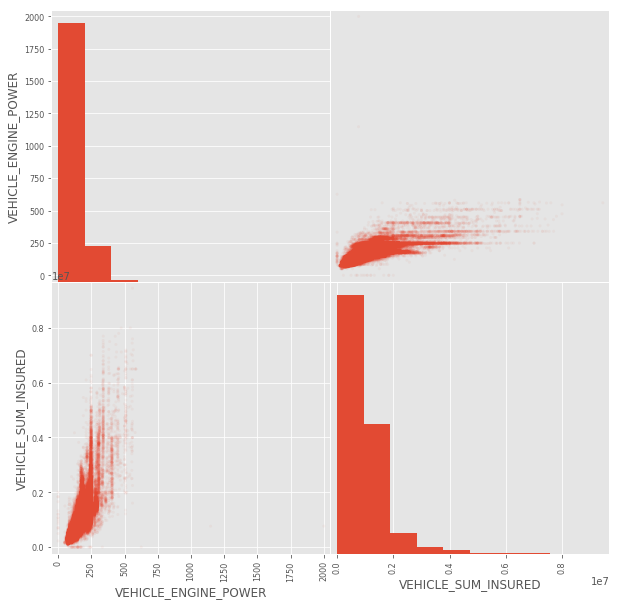

In [21]:
from pandas.plotting import scatter_matrix
scatter_matrix(data[['VEHICLE_ENGINE_POWER','VEHICLE_SUM_INSURED']], alpha=0.05, figsize=(10, 10));

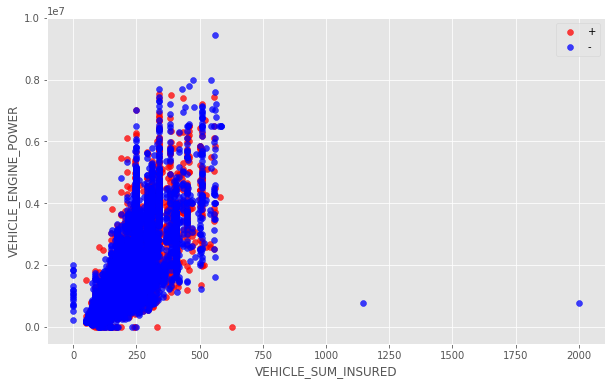

In [74]:
col1 = 'VEHICLE_ENGINE_POWER'
col2 = 'VEHICLE_SUM_INSURED'

plt.figure(figsize=(10, 6))

plt.scatter(data[col1][data['POLICY_IS_RENEWED'] == 1],
            data[col2][data['POLICY_IS_RENEWED'] == 1],
            alpha=0.75,
            color='red',
            label='+')

plt.scatter(data[col1][data['POLICY_IS_RENEWED'] == 0],
            data[col2][data['POLICY_IS_RENEWED'] == 0],
            alpha=0.75,
            color='blue',
            label='-')

plt.xlabel(col1)
plt.ylabel(col2)
plt.legend(loc='best');

Проведем исследование СКО числовых признаков.

In [19]:
data[numerical_columns+binary_columns].std().sort_values()

POLICY_COURT_SIGN                     0.03
POLICY_HAS_COMPLAINTS                 0.09
CLIENT_HAS_DAGO                       0.45
VEHICLE_IN_CREDIT                     0.47
CLIENT_HAS_OSAGO                      0.50
POLICY_PRICE_CHANGE                   0.86
POLICY_MIN_AGE                       10.69
CLAIM_AVG_ACC_ST_PRD                 17.64
VEHICLE_ENGINE_POWER                 54.12
POLICY_MIN_DRIVING_EXPERIENCE       199.93
POLICY_DEDUCT_VALUE               10418.70
VEHICLE_SUM_INSURED              690091.88
dtype: float64

Из таблицы выше видно, что у столбцов POLICY_HAS_COMPLAINTS и POLICY_COURT_SIGN показатель std (СКО) близок к нулю, т.е. эти признаки слабо изменчивы и скорее всего у них наблюдается "перекос" значений. Это тоже кандидаты на удаление признаки. Cделаем дополнительную проверку.

D:\Programms\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AF2100A898>,
      dtype=object)

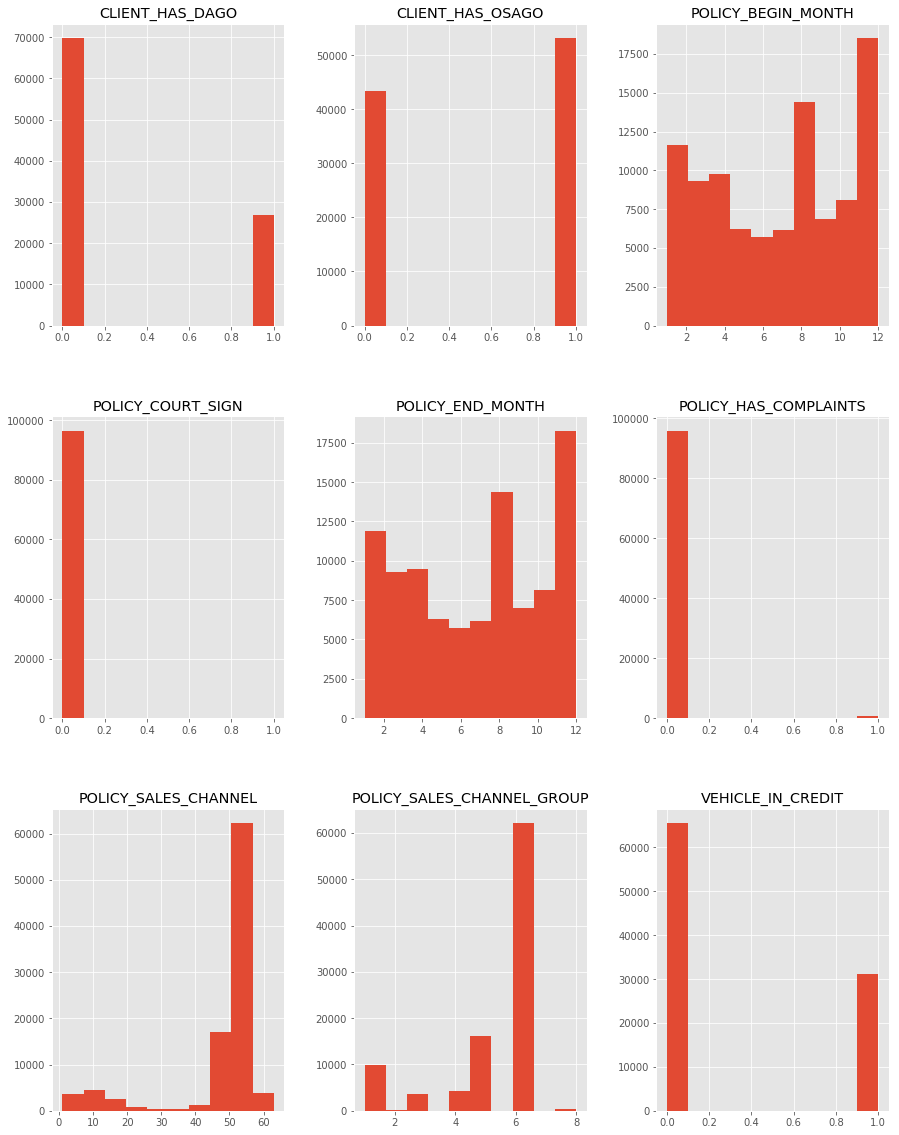

In [22]:
fig = plt.figure(figsize =(15,20))
ax = fig.gca()
data[categorical_columns+binary_columns+num_categorical_columns].hist(ax = ax)

In [23]:
sum(data[data['POLICY_COURT_SIGN']==1]['POLICY_IS_RENEWED'])

7

In [24]:
sum(data[data['POLICY_HAS_COMPLAINTS']==1]['POLICY_IS_RENEWED'])

284

#### не подтвердилось что данные не коррелируют и наблюдается сильный перекос, поэтому сильное влияние на результат не будет

In [25]:
#удаляем столбцы
for i in ['POLICY_HAS_COMPLAINTS','POLICY_COURT_SIGN']:
    binary_columns.remove(i)

## 1.5 Подготовка данных для моделирования

In [26]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
#числовые
std_sc = StandardScaler()
data[numerical_columns] = data[numerical_columns].astype(float)
data[numerical_columns] = std_sc.fit_transform(data[numerical_columns])
#категор
label_encoder_dict = {}
for i in categorical_columns+binary_columns:
    label_encoder_dict[i] = LabelEncoder()
    data[i] = label_encoder_dict[i].fit_transform(data[i])
#категор
oh_en = OneHotEncoder(sparse = False)
oh_clms = oh_en.fit_transform(data[categorical_columns+num_categorical_columns])

D:\Programms\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## 1.5 Разделение данных на тренеровочную и тестовую части

In [27]:
train_index = data[data['DATA_TYPE']=='TRAIN'].index
test_index = data[data['DATA_TYPE']=='TEST '].index

Для удобства отдельно рассмотрим столбцы, соответствующие входным признакам (это будет матрица X), а отдельно – выделенный признак (вектор Y):

In [28]:
X_train = np.concatenate([data.loc[train_index, numerical_columns+binary_columns],
                oh_clms[train_index]], axis = 1)
X_test = np.concatenate([data.loc[test_index, numerical_columns+binary_columns],
                oh_clms[test_index]], axis = 1)
Y_train = data['POLICY_IS_RENEWED'][train_index]
Y_test = data['POLICY_IS_RENEWED'][test_index]

In [31]:
from sklearn.model_selection import train_test_split
x_train_set, x_test_set, y_train_set, y_test_set = train_test_split(X_train, Y_train, test_size = 0.3, random_state = 11)

# 2. Прогнозирование
---

Для начала исследуем распределение классов в тренировочной выборке на наличие перекоса данных.

Разделение классов в тренеровочной выборке:  0.6249563992920537 0.3750436007079463


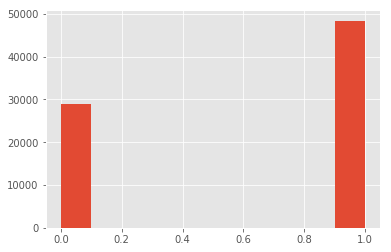

In [33]:
data['POLICY_IS_RENEWED'][train_index].hist()
c = len(train_index)
s = sum(data['POLICY_IS_RENEWED'][train_index])
print('Разделение классов в тренеровочной выборке: ', s/c, 1-s/c)

Видно из гистограммы, что есть перекос, поэтому для всех моделей выберем метрику качества  F1, потому что она учитывет перекос данных.

## 2.1 Логистическая регрессия

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer, accuracy_score

In [40]:
grid={
    "C":[0.003, 0.001, 0.01], 
    "penalty":["l1","l2"]}
f1_scorer = make_scorer(f1_score)

In [46]:
lg_clf = LogisticRegression(random_state=1777)
skf_lg = StratifiedKFold(n_splits=5, shuffle=True, random_state=1777)
logreg_cv=GridSearchCV(lg_clf,grid, n_jobs=2, cv=skf_lg, verbose=1000, scoring=f1_scorer)
logreg_cv.fit(x_train_set,y_train_set)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
Memmapping (shape=(54184, 2274), dtype=float64) to new file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_14064_5184273849\14064-2681140021176-a22a9bb2234240859bdbbcfb355eba08.pkl
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,), dtype=int32).
Memmapping (shape=(54184, 2274), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_14064_5184273849\14064-2681140021176-a22a9bb2234240859bdbbcfb355eba08.pkl
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,), dtype=int32).
Memmapping (shape=(54

[Parallel(n_jobs=2)]: Done  16 tasks      | elapsed:   42.5s
Memmapping (shape=(54184, 2274), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_14064_5184273849\14064-2681140021176-a22a9bb2234240859bdbbcfb355eba08.pkl
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43347,), dtype=int32).
Pickling array (shape=(10837,), dtype=int32).
[Parallel(n_jobs=2)]: Done  17 tasks      | elapsed:   45.8s
Memmapping (shape=(54184, 2274), dtype=float64) to old file C:\Users\ILYA\AppData\Local\Temp\joblib_memmapping_folder_14064_5184273849\14064-2681140021176-a22a9bb2234240859bdbbcfb355eba08.pkl
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(54184,), dtype=int64).
Pickling array (shape=(43348,), dtype=int32).
Pickling array (shape=(10836,), dtype=int32).
[Parallel(n_jobs=2)]: Done  18 tas

D:\Programms\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1777, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=1777, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'C': [0.0001, 0.001, 0.01], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(f1_score), verbose=1000)

In [47]:
logreg_cv.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [ ]:
lg_clf = LogisticRegression(random_state=1777, C=0.001, penalty='l2')
lg_clf.fit(x_train_set,y_train_set)

In [51]:
y_train_predict = lg_clf.predict(x_train_set)
y_train_predict_proba = lg_clf.predict_proba(x_train_set)[:,1] #все метки класса 1
y_test_predict = rfc.predict(x_test_set)
y_test_predict_proba = rfc.predict_proba(x_test_set)[:,1] #все метки класса 1
print('f1 мера на обучающей выборке: ', f1_score(y_train_set, y_train_predict.round()))
print('f1 мера на тестовой выборке: ', f1_score(y_test_set, y_test_predict.round()) )

0.6771371622619223


## 2.2 Случайный лес

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, make_scorer, accuracy_score

In [39]:
param_grid = { 
    'n_estimators': [50, 100, 200],
    'max_depth' : [12, 14, 16],
    'min_samples_split' : [2, 4, 8],
    'min_samples_leaf' : [1, 3, 5],
    'max_features': ['auto', 'sqrt']
}
f1_scorer = make_scorer(f1_score)

In [67]:
#для случайного леса
X_train_tree = data.loc[train_index, numerical_columns+categorical_columns+binary_columns+num_categorical_columns]
X_test_tree = data.loc[test_index, numerical_columns+categorical_columns+binary_columns+num_categorical_columns]
test_size = 0.3
x_train_tree_set, x_test_tree_set, y_train_set, y_test_set = train_test_split(X_train_tree, 
                                                                              Y_train, 
                                                                              test_size = test_size, 
                                                                              random_state = 11)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfc = RandomForestClassifier(oob_score = True) 

CV_rfc = GridSearchCV(estimator=rfc,
                      param_grid=param_grid, 
                      cv=skf, n
                      _jobs=8, 
                      verbose=1000,
                     scoring=f1_scorer)
CV_rfc.fit(x_train_tree_set,y_train_set)

In [ ]:
print(CV_rfc.best_params_)

In [35]:
rfc = RandomForestClassifier(max_depth = 16, 
                             max_features = 'sqrt', 
                             min_samples_leaf = 3, 
                             min_samples_split = 2, 
                             n_estimators = 300, 
                             oob_score = True, 
                             n_jobs=-1)
rfc.fit(x_train_tree_set,y_train_set)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=16, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [40]:
y_train_predict = rfc.predict(x_train_tree_set)
y_train_predict_proba = rfc.predict_proba(x_train_tree_set)[:,1] #все метки класса 1
y_test_predict = rfc.predict(x_test_tree_set)
y_test_predict_proba = rfc.predict_proba(x_test_tree_set)[:,1] #все метки класса 1
print('f1 мера на обучающей выборке: ', f1_score(y_train_set, y_train_predict.round()))
print('f1 мера на тестовой выборке: ', f1_score(y_test_set, y_test_predict.round()) )

f1 мера на обучающей выборке:  0.8822833441899419
f1 мера на тестовой выборке:  0.797886874943073


# 3. "Тюннинг" модели
---

## 3.1 Удаление признаков

In [110]:
print("значимых признаков")
for a, b in sorted(zip(rfc.feature_importances_,
                       numerical_columns+categorical_columns+binary_columns+num_categorical_columns)):
    print(a,b, sep='\t\t')

0.009813746776707514		INSURER_GENDER
0.010011987518656434		VEHICLE_IN_CREDIT
0.011460462540273289		POLICY_BRANCH
0.011799545323960419		CLIENT_HAS_DAGO
0.014126077742351466		CLIENT_HAS_OSAGO
0.014294482376104457		POLICY_SALES_CHANNEL_GROUP
0.022938489956806044		POLICY_PRV_CLM_N
0.023773304102260282		POLICY_PRV_CLM_GLT_N
0.02453198658113654		POLICY_DEDUCT_VALUE
0.025769403065095006		POLICY_CLM_N
0.027034649119223514		CLAIM_AVG_ACC_ST_PRD
0.028546045755666848		POLICY_YEARS_RENEWED_N
0.02900767528477271		CLIENT_REGISTRATION_REGION
0.031326575709407015		POLICY_SALES_CHANNEL
0.03412716235188638		POLICY_BEGIN_MONTH
0.034498882469112625		POLICY_END_MONTH
0.038432943007724756		VEHICLE_MAKE
0.03855280843227776		POLICY_CLM_GLT_N
0.04888401432938474		POLICY_INTERMEDIARY
0.052247001916844026		POLICY_MIN_DRIVING_EXPERIENCE
0.05397037849679511		VEHICLE_ENGINE_POWER
0.05609443823725308		VEHICLE_MODEL
0.057679057049226934		POLICY_MIN_AGE
0.07522098808596542		VEHICLE_SUM_INSURED
0.22585789377110757		POL

## 3.2 Добавление новых сгенерированных

## 3.3 Новое обучение и прогноз

In [ ]:
#для случайного леса
X_train_tree = data.loc[train_index, numerical_columns+categorical_columns+binary_columns+num_categorical_columns]
X_test_tree = data.loc[test_index, numerical_columns+categorical_columns+binary_columns+num_categorical_columns]
test_size = 0.3
x_train_tree_set, x_test_tree_set, y_train_set, y_test_set = train_test_split(X_train_tree, 
                                                                              Y_train, 
                                                                              test_size = test_size, 
                                                                              random_state = 11)

In [ ]:
rfc = RandomForestClassifier(max_depth = 16, 
                             max_features = 'sqrt', 
                             min_samples_leaf = 3, 
                             min_samples_split = 2, 
                             n_estimators = 300, 
                             oob_score = True, 
                             n_jobs=-1)
rfc.fit(x_train_tree_set,y_train_set)

In [ ]:
y_train_predict = rfc.predict(x_train_tree_set)
y_train_predict_proba = rfc.predict_proba(x_train_tree_set)[:,1] #все метки класса 1
y_test_predict = rfc.predict(x_test_tree_set)
y_test_predict_proba = rfc.predict_proba(x_test_tree_set)[:,1] #все метки класса 1
print('f1 мера на обучающей выборке: ', f1_score(y_train_set, y_train_predict.round()))
print('f1 мера на тестовой выборке: ', f1_score(y_test_set, y_test_predict.round()) )

# 4. Анализ модели и выводы
---

После вычислений делаем выводы

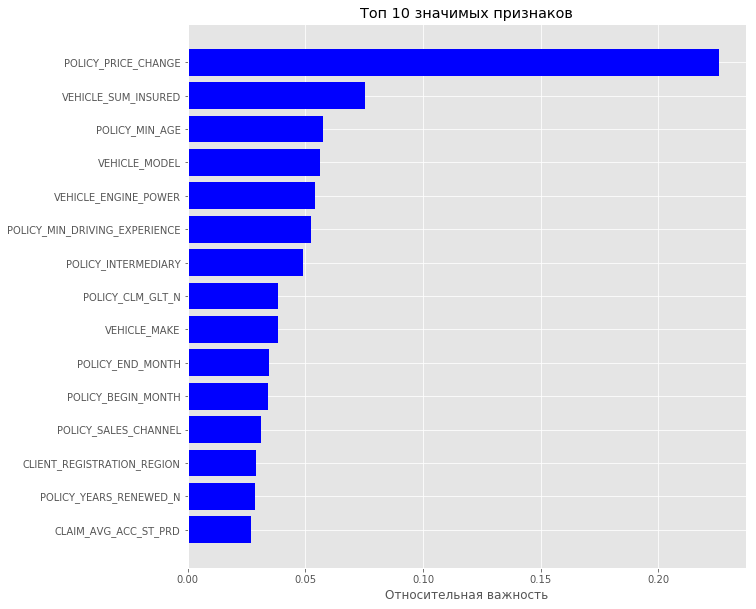

In [99]:
features = numerical_columns+categorical_columns+binary_columns+num_categorical_columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[10:]
plt.figure(figsize=(10,10))
plt.title('Топ 10 значимых признаков')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Относительная важность')
plt.show()

Из диаграммы видим, что наиболее важные признаки это: 

    -POLICY_PRICE_CHANGE	Как поменялась премия при пролонгации
    sdfsdf
    sdfsdf

## Сохранение тестовых результатов

In [68]:
Y_test_predict = rfc.predict(X_test_tree)
Y_test_predict_proba = rfc.predict_proba(X_test_tree)[:,1] #все метки класса 1

Прогнозные значения сохраянем в файл

In [149]:
rez_table = pd.DataFrame()
rez_table['POLICY_ID'] = data['POLICY_ID'][test_index]
rez_table['POLICY_IS_RENEWED'] = pd.DataFrame(Y_test_predict)
rez_table['POLICY_IS_RENEWED_PROBABILITY'] = pd.DataFrame(Y_test_predict_proba)

PATH_TO_DATA_SAVE = 'D:\Задача 1\Pavlov_Rezult.csv'
rez_table.to_csv(PATH_TO_DATA_SAVE, header=1, sep=',', 
          quotechar='"', encoding='utf-8', index=False)

In [151]:
rez_table.head()

,POLICY_ID,POLICY_IS_RENEWED,POLICY_IS_RENEWED_PROBABILITY
9,10,1.0,0.77
11,12,1.0,0.68
12,13,0.0,0.41
21,22,0.0,0.48
36,37,0.0,0.47


# 5. Дальнейшие планы
---

#### 1) применить XGBoost
#### 2) обогащение данных
#### 3) слияние моделей
---